`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   
`Вариант 11`
`Упражнение 1`
`Задача 2.2`
`Лазарев Н.С.`

# Данные задачи:

`Характеристики для 2.2 задачи:`

$train\_percent = 0.15$

# Выполнение:

Повторить расчёты, меняя характеристики согласно своему варианту (см. последний столбец таблицы с вариантами). Проанализировать, как меняется MSE при изменении характеристик.


In [2]:
# загрузка пакетов
import numpy as np
import random

In [3]:
np.random.seed(11) #ядро

# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.15

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all*train_percent), replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(25 + 0.02*x - 0.003*(x-45)**2 + 0.00006*(x-54)**3)
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x)+res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)



### График №1.   

In [4]:
# загрузка пакетов
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

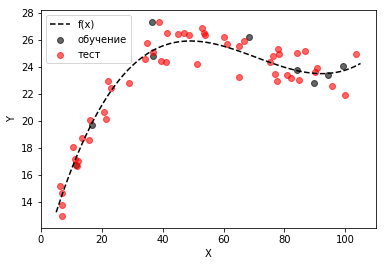

In [5]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train,y_train, c='black', label='обучение', alpha=0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, c='red', label='тест', alpha=0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(x)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
#  легенда
plt.legend()
plt.show

## График №2

In [6]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

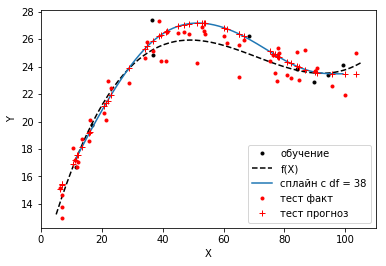

In [7]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2)/len(y_train),
          sum((y_test - y_hat_test)**2)/len(y_test)]

Ошибки на обучающей и тестовой выборках составили соответственно:

In [8]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.55, 1.35])

In [9]:
#  Теперь строим модели с df от 2 до 40 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0]*2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'], 
index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = \
    sum((y_train - y_train_hat)**2)/len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = \
    sum((y_test - y_test_hat)**2)/len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:  

In [10]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
10,0.552186,1.347533
11,0.552186,1.347533
12,0.552186,1.347533
13,0.552186,1.347533
14,0.552186,1.347533
15,0.552186,1.347533
16,0.552186,1.347533
17,0.552186,1.347533
18,0.552186,1.347533
19,0.552186,1.347533


Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели. 

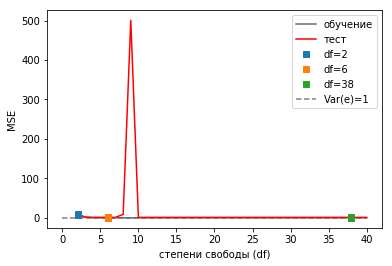

In [11]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')